In [34]:
from datasets import load_dataset

In [35]:
dataset = load_dataset("maartengr/arxiv_nlp")["train"]
dataset

Dataset({
    features: ['Titles', 'Abstracts', 'Years', 'Categories'],
    num_rows: 44949
})

In [36]:
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

In [37]:
print(titles[0])
print()
print(abstracts[0])

Introduction to Arabic Speech Recognition Using CMUSphinx System

  In this paper Arabic was investigated from the speech recognition problem
point of view. We propose a novel approach to build an Arabic Automated Speech
Recognition System (ASR). This system is based on the open source CMU Sphinx-4,
from the Carnegie Mellon University. CMU Sphinx is a large-vocabulary;
speaker-independent, continuous speech recognition system based on discrete
Hidden Markov Models (HMMs). We build a model using utilities from the
OpenSource CMU Sphinx. We will demonstrate the possible adaptability of this
system to Arabic voice recognition.



In [38]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("thenlper/gte-small")
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)
embeddings.shape

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

(44949, 384)

In [39]:
from umap import UMAP

umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

In [40]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric="euclidean", cluster_selection_method="eom"
).fit(reduced_embeddings)

clusters = hdbscan_model.labels_
clusters

array([ -1,  -1,  -1, ...,  -1, 132,  -1])

In [41]:
len(set(clusters))

153

In [42]:
import numpy as np

cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[index][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



In [43]:
import pandas as pd

reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric="cosine", random_state=42
).fit_transform(embeddings)

In [44]:
df = pd.DataFrame(reduced_embeddings, columns=["x","y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

clusters_df = df.loc[df['cluster'] != "-1", :]
outliers_df = df.loc[df['cluster'] == '-1', :]

df

x         y                                              title  \
0      5.013245  0.231148  Introduction to Arabic Speech Recognition Usin...   
1      5.007167  0.227746  Arabic Speech Recognition System using CMU-Sph...   
2      4.421731 -0.293374  On the Development of Text Input Method - Less...   
3      0.030039 -1.022420  Network statistics on early English Syntax: St...   
4      4.342441  1.932786  Segmentation and Context of Literary and Music...   
...         ...       ...                                                ...   
44944  2.177875 -2.064166  Resolution of Verb Ellipsis in Japanese Senten...   
44945  3.516389 -1.492558  An Example-Based Approach to Japanese-to-Engli...   
44946 -0.692350 -1.465117  Deduction over Mixed-Level Logic Representatio...   
44947  3.415327 -0.013947   HMM Specialization with Selective Lexicalization   
44948 -0.701599 -1.447238  Mixed-Level Knowledge Representation and Varia...   

      cluster  
0          -1  
1          -1  
2          -1  
3          -1  
4          27  
...       ...  
44944      -1  
44945      -1  
44946      -1  
44947     132  
44948      -1  

[44949 rows x 4 columns]

(-7.543319487571717, 11.474113726615906, -7.32205650806427, 11.29334089756012)

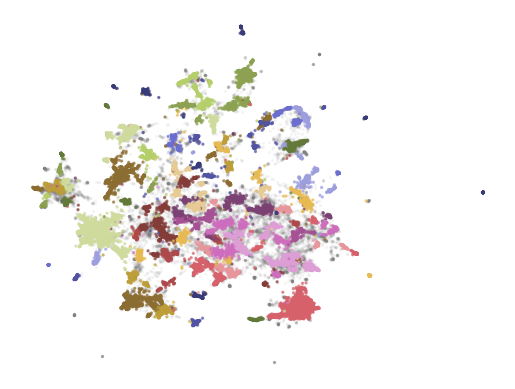

In [45]:
import matplotlib.pyplot as plt

plt.scatter(outliers_df['x'], outliers_df['y'], alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df['x'], clusters_df['y'], c=clusters_df['cluster'].astype(int),
    alpha=0.6, s=2, cmap='tab20b'
)
plt.axis("off")

## BERTopic

In [46]:
!pip install bertopic

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [47]:
from bertopic import BERTopic

topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2025-06-13 14:01:52,938 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-13 14:02:37,535 - BERTopic - Dimensionality - Completed ✓
2025-06-13 14:02:37,539 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-13 14:02:38,985 - BERTopic - Cluster - Completed ✓
2025-06-13 14:02:38,996 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-13 14:02:42,693 - BERTopic - Representation - Completed ✓


In [48]:
topic_model.get_topic_info()

Topic  Count                                           Name  \
0       -1  14526                               -1_the_of_and_to   
1        0   2120                 0_question_qa_answer_questions   
2        1   2110                   1_speech_asr_recognition_end   
3        2   1549          2_medical_clinical_biomedical_patient   
4        3    873  3_summarization_summaries_summary_abstractive   
..     ...    ...                                            ...   
148    147     53         147_coherence_discourse_paragraph_text   
149    148     52                 148_long_context_window_length   
150    149     52           149_backdoor_attacks_attack_triggers   
151    150     51   150_diffusion_generation_autoregressive_text   
152    151     50            151_reviews_review_customer_product   

                                        Representation  \
0    [the, of, and, to, in, we, that, for, language...   
1    [question, qa, answer, questions, answering, a...   
2    [speech, asr, recognition, end, acoustic, audi...   
3    [medical, clinical, biomedical, patient, healt...   
4    [summarization, summaries, summary, abstractiv...   
..                                                 ...   
148  [coherence, discourse, paragraph, text, cohesi...   
149  [long, context, window, length, llms, memory, ...   
150  [backdoor, attacks, attack, triggers, poisoned...   
151  [diffusion, generation, autoregressive, text, ...   
152  [reviews, review, customer, product, rating, c...   

                                   Representative_Docs  
0    [  Measuring the semantic similarity between t...  
1    [  The ability to ask questions is important i...  
2    [  Humans are capable of processing speech by ...  
3    [  Electronic health records (EHR) contain nar...  
4    [  We present a novel divide-and-conquer metho...  
..                                                 ...  
148  [  While there has been significant progress t...  
149  [  Extending the context window of large langu...  
150  [  Deep neural networks (DNNs) and natural lan...  
151  [  Diffusion models have achieved great succes...  
152  [  User-generated texts such as reviews and so...  

[153 rows x 5 columns]

In [49]:
topic_model.get_topic_info(0)

Topic  Count                            Name  \
0      0   2120  0_question_qa_answer_questions   

                                      Representation  \
0  [question, qa, answer, questions, answering, a...   

                                 Representative_Docs  
0  [  The ability to ask questions is important i...

In [50]:
topic_model.find_topics("topic modeling")

([23, -1, 2, 27, 35],
 [0.9551587, 0.9109953, 0.9086731, 0.90823543, 0.90540934])

In [51]:
topic_model.get_topic(22)

[('rnns', 0.019385831992915978),
 ('recurrent', 0.01710072470881059),
 ('syntactic', 0.016086831851305893),
 ('lstm', 0.015655046099098527),
 ('rnn', 0.012760068718931707),
 ('agreement', 0.012301206097442893),
 ('neural', 0.012169990674497599),
 ('networks', 0.012054017095484024),
 ('memory', 0.010619059984074851),
 ('verb', 0.009677112395397541)]

In [52]:
topic_model.topics_[titles.index('BERTopic: Neural topic modeling with a class-based TF-IDF procedure')]

23

In [53]:
fig = topic_model.visualize_documents(
    titles,
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

fig.update_layout(font=dict(size=16))

In [54]:
topic_model.visualize_barchart()

In [55]:
topic_model.visualize_heatmap(n_clusters=30)

In [56]:
topic_model.visualize_hierarchy()

## Representation Model

In [57]:
from copy import deepcopy

original_topics = deepcopy(topic_model.topic_representations_)

In [58]:
def topic_differences(model, original_topics, nr_topics=5):
    df = pd.DataFrame(columns = ["Topic", "Original", "Updated"])

    for topic in range(nr_topics):
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]

    return df

In [59]:
from bertopic.representation import KeyBERTInspired
from bertopic import BERTopic

representation_model = KeyBERTInspired()

topic_model.update_topics(abstracts, representation_model=representation_model)

topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | qa | answer | questions | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  medical | clinical | biomedical | patient | he...   
3      3  summarization | summaries | summary | abstract...   
4      4      hate | offensive | speech | detection | toxic   

                                             Updated  
0  answering | questions | comprehension | answer...  
1      phonetic | speech | language | spoken | voice  
2            nlp | clinical | ehr | ehrs | annotated  
3  summarization | summarizers | summaries | summ...  
4  hate | hateful | language | offensive | cyberb...

In [60]:
from bertopic.representation import MaximalMarginalRelevance

representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model.update_topics(abstracts, representation_model=representation_model)

topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | qa | answer | questions | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  medical | clinical | biomedical | patient | he...   
3      3  summarization | summaries | summary | abstract...   
4      4      hate | offensive | speech | detection | toxic   

                                             Updated  
0   questions | comprehension | hop | knowledge | to  
1           speech | asr | error | model | automatic  
2  clinical | biomedical | patient | healthcare |...  
3  summarization | extractive | factual | evaluat...  
4      hate | toxic | abusive | comments | platforms

## Text Generation

In [76]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

# Update our topic representations using Flan-T5
generator = pipeline('text2text-generation', model='google/flan-t5-small')
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Device set to use cuda:0
100%|██████████| 153/153 [00:12<00:00, 12.70it/s]


Topic                                           Original  \
0      0     question | qa | answer | questions | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  medical | clinical | biomedical | patient | he...   
3      3  summarization | summaries | summary | abstract...   
4      4      hate | offensive | speech | detection | toxic   

                                 Updated  
0         question answering |  |  |  |   
1      Speech representation |  |  |  |   
2               Science/Tech |  |  |  |   
3  Abstractive summarization |  |  |  |   
4               Science/Tech |  |  |  |

In [73]:
!pip install datamapplot

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 88.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 100.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.2 MB/s eta 0:00:00
  Created wheel for Pyqtree: filename=Pyqtree-1.0.0-py3-none-any.whl size=5969 sha256=baae6361b267494821638b318bc8693b06c6ec8c50695df87fba7870b03b1ac8
  Stored in directory: /root/.cache/pip/wheels/4c/87/93/c44242a244e4cea2cb9f5414ec450ababd7acac8b3377c3f9e
Successfully built Pyqtree
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.2
    Uninstalling matplotlib-3.7.2:
      Successfully uninstalled matplotlib-3.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that a

In [77]:
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings,
    width=1200,
)

NameError: name 'datamapplot' is not defined

In [78]:
!pip install wordcloud

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [79]:
topic_model.update_topics(abstracts, top_n_words=500)

2025-06-13 14:44:19,950 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


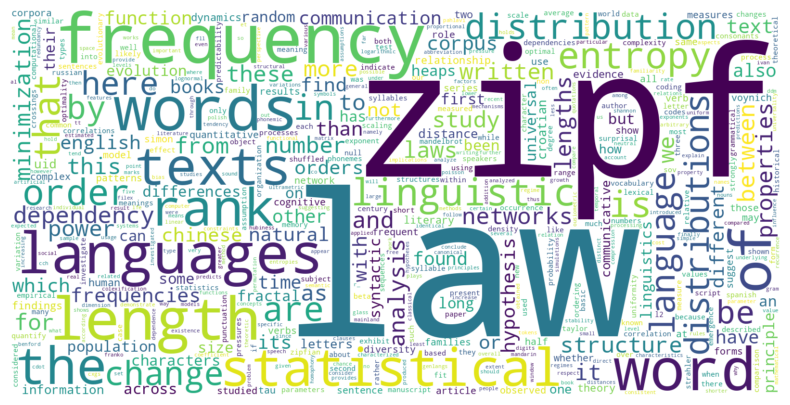

In [80]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    plt.figure(figsize=(10,5))
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000, width=1600, height=800)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

create_wordcloud(topic_model, topic=17)